# <p style="text-align: center;">Findings about the Chicago PD ISR data set</p>
## <p style="text-align: center;">Profiling and Compliance</p>

***Background:*** In this second Notebook, I will be looking at whether the CPD does racial profiling when choosing suspect to stop and frisk. In the future it would also be interesting to look at other forms of profiling e.g. vehicle year, make and style; hair style and clothing, etc.

Also, I will examine how the CPD is compliant to guidelines (e.g. asking for consent and giving receipt before and after patting down, recording the procedure with cameras) in each communities.

In [1]:
# Python 3.8.0
import io
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from functools import reduce

from IPython.display import Image

import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff

pd.options.display.max_columns = None

In [2]:
# Load Data
df_main = pd.read_csv('ISR-1-Jan-2018--31-Dec-2019-Juv-Redacted.csv',
                     dtype={'DISTRICT': str, 'BEAT': str})

D:\Python37.4\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning:

Columns (12,34,97,98,99,100,107,108,109,143,145,147) have mixed types.Specify dtype option on import or set low_memory=False.



In [3]:
def zip_validate(s):
    try:
        return str(int(s))
    except ValueError:
        return '0'

df_main['ZIP_CD'] = df_main['ZIP_CD'].apply(zip_validate)

In [4]:
plt.close()

### <p style="text-align: center;">Fig 1. Total Number of ISR of yr 2018-2019 by Race</p>
#### <p style="text-align: center;">Enforcement Action Taken vs No Action Taken</p>

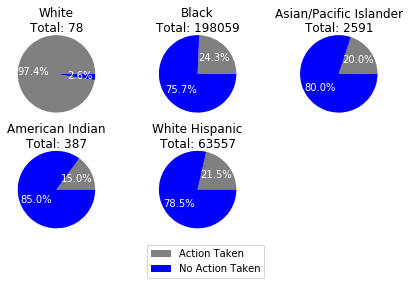

In [5]:
# Race
races = ['WHI', 'BLK', 'API', 'I', 'WWH']
names = ['White', 'Black', 'Asian/Pacific Islander', 'American Indian', 'White Hispanic']
tos = list()
crs = list()
ins = list()
for race in races:
    total = sum(df_main['RACE_CODE_CD'] == race)
    i = sum((df_main['RACE_CODE_CD'] == race) & (df_main['ENFORCEMENT_ACTION_TAKEN_I'] == 'N'))
    c = total - i
    tos.append(total)
    crs.append(c)
    ins.append(i)
fig, axes = plt.subplots(2, 3)
for i, ax in enumerate(axes.flatten()):
    if i > 4:
        break
    _ = ax.pie([crs[i], ins[i]], radius=1.35, autopct="%.1f%%", colors=['grey', 'blue'], textprops={'color': 'white'})
    _ = ax.set_title(names[i] + '\n' + 'Total: %s' % tos[i])
_ = fig.delaxes(axes.flatten()[-1])
_ = fig.subplots_adjust(bottom=0.5, wspace=0)
_ = axes.flatten()[4].legend(['Action Taken', 'No Action Taken'], fancybox=False,bbox_to_anchor=(1.5, -0.2))
plt.tight_layout()
plt.show()
plt.close()

***Note:***  According to the 2010 census, Chicago's demographics by race is 31.7% non-Hispanic White, 32% Black, 28% Hispanic and 5% Asian. Apparently black and hispanic people are most often "stop-and-frisk"ed.

In [6]:
# Load GeoJson data
with open('Boundaries - ZIP Codes.geojson', 'r') as f:
    geodata_zip = json.load(f)

In [7]:
# Total
df_tn_z = df_main['ZIP_CD'].value_counts()
df_tn_z = pd.DataFrame(data=zip(df_tn_z.index, df_tn_z.values), columns=['zip', 'num_tot'])

In [8]:
# Compliance - consent and receipt
df_tn_pat = df_main[df_main['PAT_DOWN_I'] == 'Y']['ZIP_CD'].value_counts()
df_tn_pat = pd.DataFrame(data=zip(df_tn_pat.index, df_tn_pat.values), columns=['zip', 'num_pat'])
df_tn_con = df_main[(df_main['PAT_DOWN_CONSENT_I'] == 'Y') & (df_main['PAT_DOWN_I'] == 'Y')]['ZIP_CD'].value_counts()
df_tn_con = pd.DataFrame(data=zip(df_tn_con.index, df_tn_con.values), columns=['zip', 'num_con'])
df_tn_rec = df_main[(df_main['PAT_DOWN_RECEIPT_GIVEN_I'] == 'Y') & (df_main['PAT_DOWN_I'] == 'Y')]['ZIP_CD'].value_counts()
df_tn_rec = pd.DataFrame(data=zip(df_tn_rec.index, df_tn_rec.values), columns=['zip', 'num_rec'])

In [9]:
# Compliance - camera
df_tn_cam = df_main[(df_main['BODY_CAMERA_I'] == 'Y') | (df_main['CAR_CAMERA_I'] == 'Y')]['ZIP_CD'].value_counts()
df_tn_cam = pd.DataFrame(data=zip(df_tn_cam.index, df_tn_cam.values), columns=['zip', 'num_cam'])

In [10]:
df_zip = reduce(lambda x, y: pd.merge(x, y, on ='zip'), [df_tn_z, df_tn_pat, df_tn_con, df_tn_rec, df_tn_cam])

In [11]:
# Consent
fig = go.Figure(go.Choroplethmapbox(featureidkey='properties.zip',geojson=geodata_zip, locations=df_zip['zip'], z=df_zip['num_con'] / df_zip['num_pat'],
                                    colorscale="greens", zmin=0, zmax=1.0,
                                    marker_opacity=0.7, marker_line_width=0))
fig.update_layout(mapbox_style="carto-positron",
                  mapbox_zoom=9.1, mapbox_center = {"lat": 41.823832, "lon": -87.623177})
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
img_bytes = fig.to_image(format="png")

### <p style="text-align: center;">Fig 1. Fraction of Consensual Pat-Down of yr 2018-2019 by Zip Code</p>

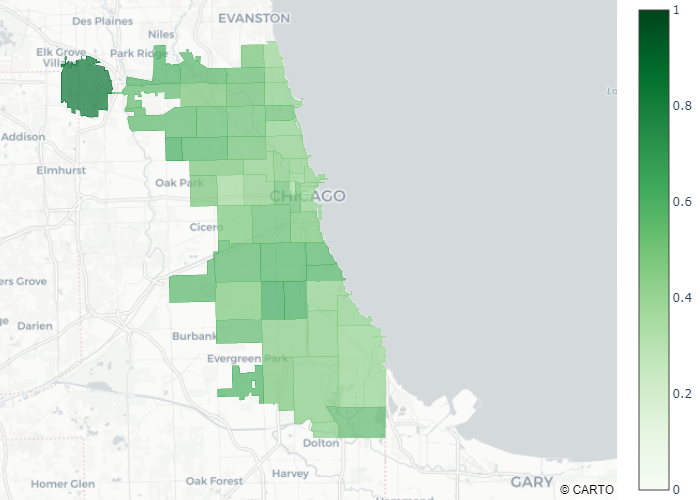

In [12]:
Image(img_bytes)

***Note:*** This figures shows the fraction of consensual pat-downs. Given that the officer does not always have to ask for consent before patting down (per Special Order S04-13-09 by CPD), the results indicates more about the fraction of "calm" encounters between the officer(s) and the suspect. The result does not vary much across different communities, except that at O'Hare it is almost 1.0, which is reasonable.

In [13]:
# Receipt
fig = go.Figure(go.Choroplethmapbox(featureidkey='properties.zip',geojson=geodata_zip, locations=df_zip['zip'], z=df_zip['num_rec'] / df_zip['num_pat'],
                                    colorscale="greens", zmin=0, zmax=1.0,
                                    marker_opacity=0.7, marker_line_width=0))
fig.update_layout(mapbox_style="carto-positron",
                  mapbox_zoom=9.1, mapbox_center = {"lat": 41.823832, "lon": -87.623177})
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
img_bytes = fig.to_image(format="png")

### <p style="text-align: center;">Fig 2. Fraction of Receipt Given after Pat-Down by Zip Code</p>

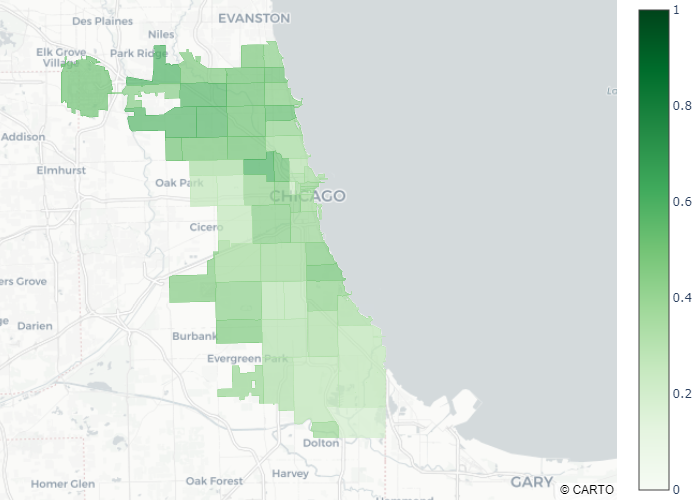

In [14]:
Image(img_bytes)

***Note:*** It is required by Special Order S04-13-09 that a Investigatory Stop Receipt containing the incident number and other information is given to the subject after the stop. However, it is clear that this requirement has not been well-executed. Also, there is a clear pattern where the furthure down south, the less receipts were given.

In [15]:
# Camera
fig = go.Figure(go.Choroplethmapbox(featureidkey='properties.zip',geojson=geodata_zip, locations=df_zip['zip'], z=df_zip['num_cam'] / df_zip['num_pat'],
                                    colorscale="greens", zmin=0, zmax=1.0,
                                    marker_opacity=0.7, marker_line_width=0))
fig.update_layout(mapbox_style="carto-positron",
                  mapbox_zoom=9.1, mapbox_center = {"lat": 41.823832, "lon": -87.623177})
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
img_bytes = fig.to_image(format="png")

### <p style="text-align: center;">Fig 3. Fraction of Camera-Recorded ISR by Zip Code</p>

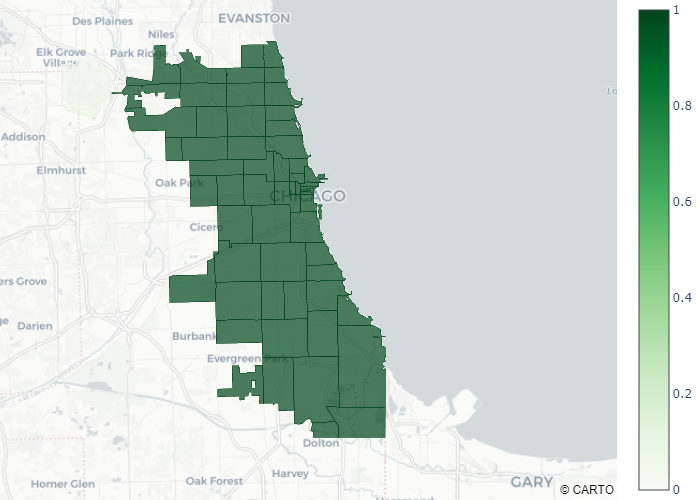

In [16]:
Image(img_bytes)

***Note:*** This figure shows the fraction on ISRs that are recorded either with a body camera or a car camera. It is good to see that the CPD is doing a good job complying with the regulation.